### Import libraries

In [1]:
import numpy as np
import cv2 as cv2
import glob
import open3d as o3d
import matplotlib.pyplot as plt

### Get image paths

In [2]:
images_left = glob.glob('Stereo_calibration_images/left-*.png')
images_right = glob.glob('Stereo_calibration_images/right-*.png')
images_left.sort()
images_right.sort()
print(len(images_left))
print(len(images_right))

50
50


### Undistort and rectify based on chessboard features

In [3]:
nb_horizontal = 9  # Number of vertical inner corners
nb_vertical = 6    # Number of horizontal inner corners

# Termination criteria (default of cv2)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)  * 36

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = [] # 2d points in image plane.

for fname_left, fname_right in zip(images_left, images_right):
    img_left = cv2.imread(fname_left)
    img_right = cv2.imread(fname_right)

    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    # Find corners for left and right images
    ret_left, corners_left = cv2.findChessboardCorners(gray_left, (nb_vertical, nb_horizontal), cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FILTER_QUADS)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, (nb_vertical, nb_horizontal), cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FILTER_QUADS)
    
    # If found, add object points, image points (after refining them)
    if ret_left and ret_right == True:
        objpoints.append(objp)

        corners_left = cv2.cornerSubPix(gray_left, corners_left, (11,11), (-1,-1), criteria)
        imgpoints_left.append(corners_left)

        corners_right = cv2.cornerSubPix(gray_right, corners_right, (11,11), (-1,-1), criteria)
        imgpoints_right.append(corners_right)

In [4]:
ret, left_mtx, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints, imgpoints_left, gray_left.shape[::-1], None, None)
ret, right_mtx, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints, imgpoints_right, gray_right.shape[::-1], None, None)

In [5]:
stereocalibration_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC

ret, c_mat_l, dist1, c_mat_r, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, left_mtx, dist_left, right_mtx, dist_right, gray_right.shape[::-1], flags = stereocalibration_flags)

In [6]:
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(c_mat_l, dist1, c_mat_r, dist2, gray_right.shape[::-1], R, T, flags=cv2.CALIB_ZERO_DISPARITY)

In [7]:
leftMapX, leftMapY = cv2.initUndistortRectifyMap(c_mat_l, dist1, R1, P1, gray_left.shape[::-1], cv2.CV_32FC1)

rightMapX, rightMapY = cv2.initUndistortRectifyMap(c_mat_r, dist2, R2, P2, gray_right.shape[::-1], cv2.CV_32FC1)

In [8]:
fname_left = 'Stereo_calibration_images/left-0000.png'
leftFrame = cv2.imread(fname_left)
gray_l = cv2.cvtColor(leftFrame, cv2.COLOR_BGR2GRAY)
h_l,  w_l = gray_l.shape[:2]

fname_right = 'Stereo_calibration_images/right-0000.png'
rightFrame = cv2.imread(fname_right)
gray_r = cv2.cvtColor(rightFrame, cv2.COLOR_BGR2GRAY)
h_r,  w_r = gray_r.shape[:2]

In [9]:
left_rect = cv2.remap(gray_l, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
right_rect = cv2.remap(gray_r, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

### Undistorted and rectified example 1

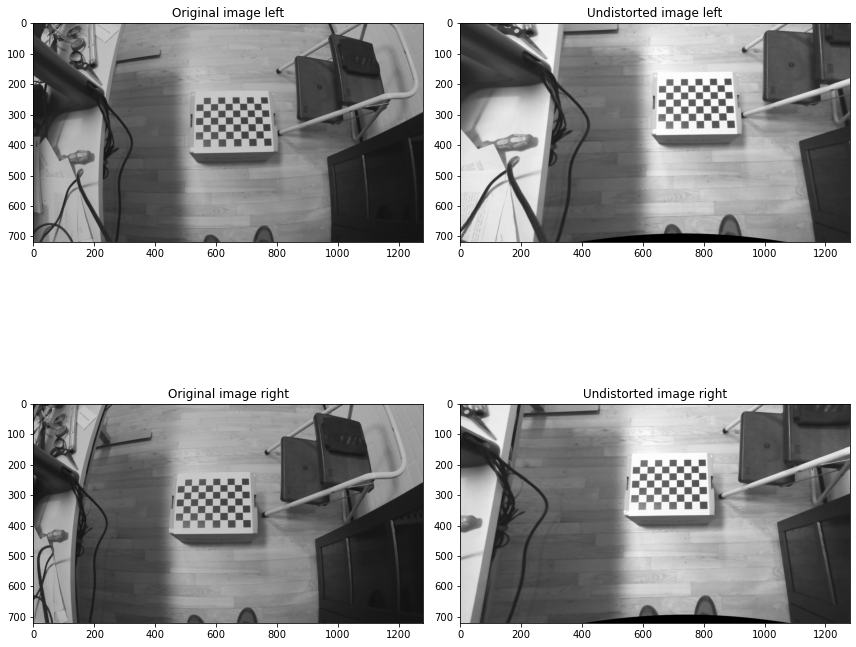

In [10]:
fig, ax = plt.subplots(2,2, figsize = (12,12))

ax[0][0].imshow(leftFrame)
ax[0][0].set_title('Original image left')

ax[0][1].imshow(left_rect, cmap='gray')
ax[0][1].set_title('Undistorted image left')


ax[1][0].imshow(rightFrame)
ax[1][0].set_title('Original image right')

ax[1][1].imshow(right_rect, cmap='gray')
ax[1][1].set_title('Undistorted image right')

plt.tight_layout()

### Undistorted and rectified example 2

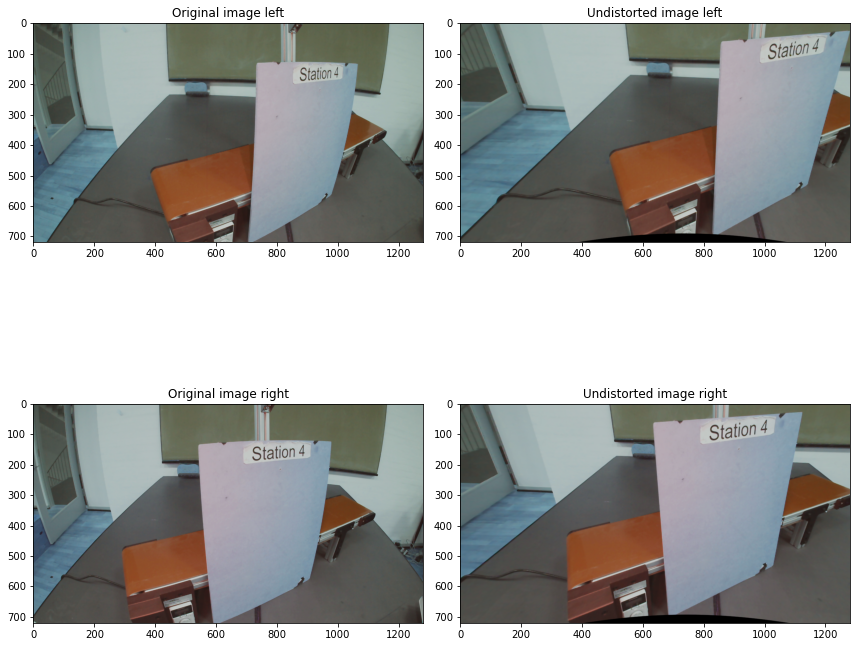

In [11]:
fname_left = './With_Occlusions/left/1585434750_371934652_Left.png'
leftFrame = cv2.imread(fname_left)
gray_l = cv2.cvtColor(leftFrame, cv2.COLOR_BGR2GRAY)
h_l,  w_l = gray_l.shape[:2]

fname_right = './With_Occlusions/right/1585434750_371934652_Right.png'
rightFrame = cv2.imread(fname_right)
gray_l = cv2.cvtColor(rightFrame, cv2.COLOR_BGR2GRAY)
h_l,  w_l = gray_l.shape[:2]


left_rect = cv2.remap(leftFrame, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
right_rect = cv2.remap(rightFrame, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

fig, ax = plt.subplots(2,2, figsize = (12,12))

ax[0][0].imshow(leftFrame)
ax[0][0].set_title('Original image left')

ax[0][1].imshow(left_rect)
ax[0][1].set_title('Undistorted image left')


ax[1][0].imshow(rightFrame)
ax[1][0].set_title('Original image right')

ax[1][1].imshow(right_rect)
ax[1][1].set_title('Undistorted image right')

plt.tight_layout()

## Depth map construction

from https://mynt-eye-d-sdk.readthedocs.io/en/v1.7.7/product/params_d1000_120.html
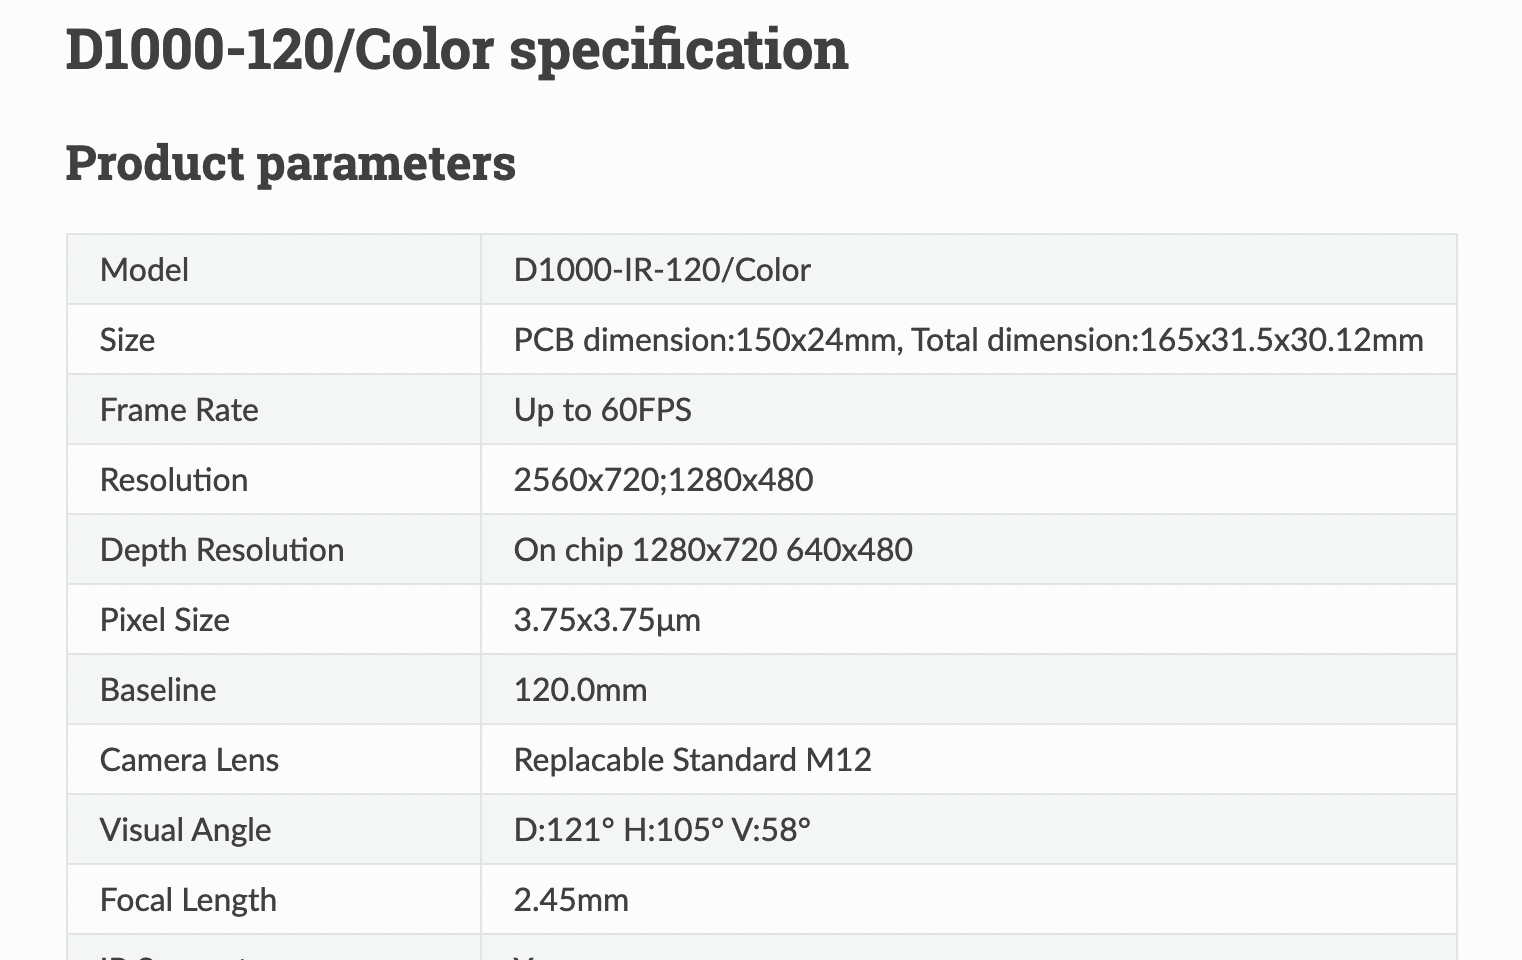

In [12]:
fname_disp_left = './Without_Occlusions/left/1585434286_940901995_Left.png'
imgL = cv2.imread(fname_disp_left)
leftRect = cv2.remap(imgL, leftMapX, leftMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
leftGray = cv2.cvtColor(leftRect, cv2.COLOR_BGR2GRAY)

fname_disp_right = './Without_Occlusions/right/1585434286_940901995_Right.png'
imgR = cv2.imread(fname_disp_right)
rightRect = cv2.remap(imgR, rightMapX, rightMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
rightGray = cv2.cvtColor(rightRect, cv2.COLOR_BGR2GRAY)

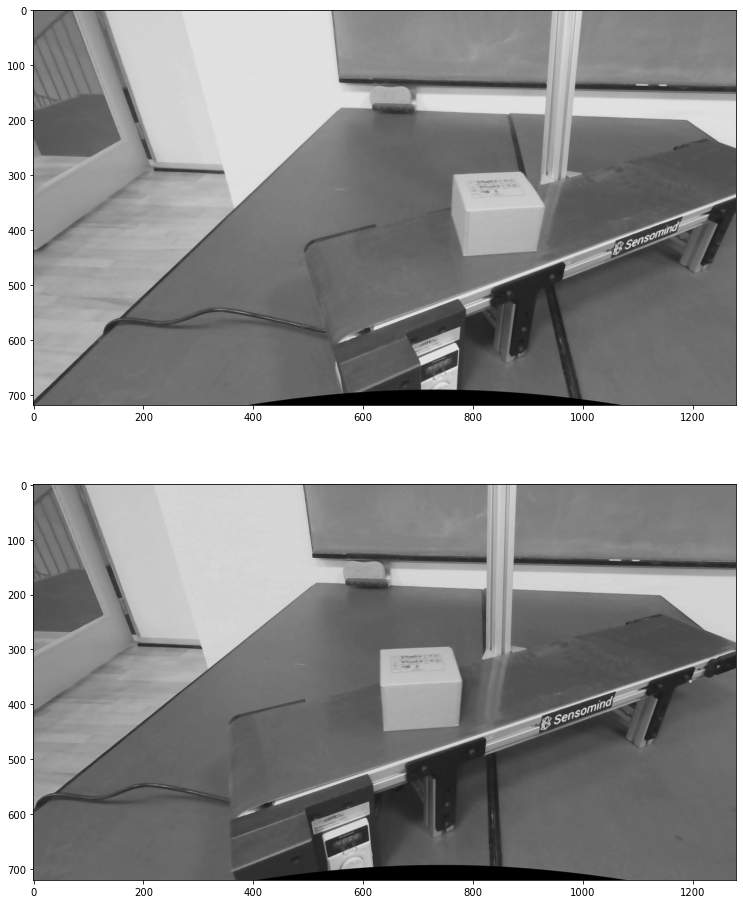

In [13]:
fig, ax = plt.subplots(2, 1, figsize = (16,16))
ax[0].imshow(leftGray, 'gray')
ax[1].imshow(rightGray, 'gray')

### Disparity map for image

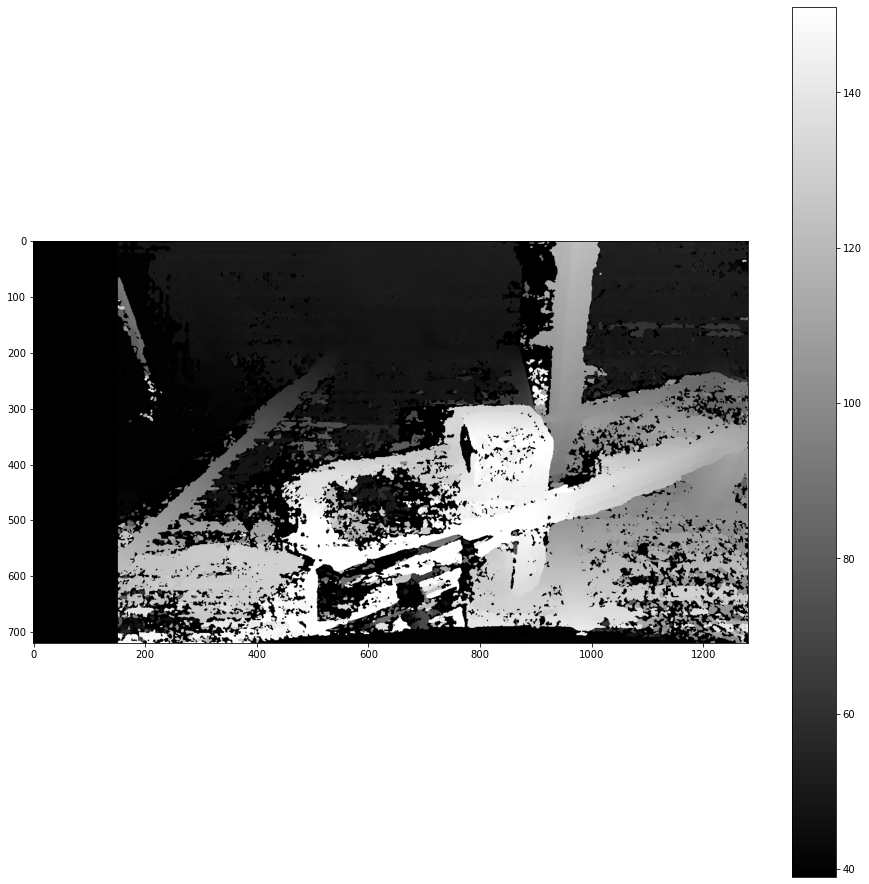

In [14]:
block_size = 7
min_disp = 40
max_disp = 7 * 16
num_disp = max_disp 

stereo_2 = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = block_size,
    uniquenessRatio = 5,
    speckleWindowSize = 5,
    speckleRange = 5,
    disp12MaxDiff = 10,
    P1 = 8 * 3 * block_size ** 2,
    P2 = 32 * 3 * block_size ** 2
)

disparity_2 = stereo_2.compute(leftRect, rightRect).astype(np.float32)  / 16.0

fig, ax = plt.subplots(figsize = (16,16))
# ax[0].imshow(left_rect, 'gray')
# ax[1].imshow(right_rect, 'gray')
image = ax.imshow(disparity_2, cmap = 'gray')
plt.colorbar(image)

In [15]:
print(f'Focal length in pixels: {c_mat_l[0][0]}')

Focal length in pixels: 703.653049836209


### Use camera specs to calculate distance image


    Distance from center row downward: 32.99 mm,
    Distance from center column right: 164.95 mm,
    Distance from camera to center: 555.37 mm,
    Depth of object in re: 580.29 mm


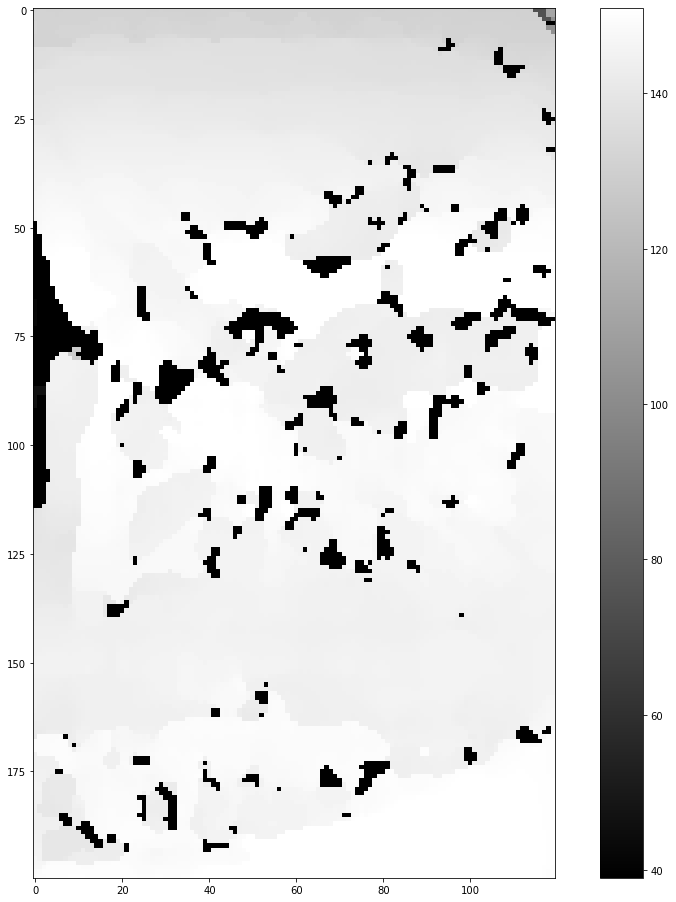

In [16]:
def object_xyzd(start_x, end_x, start_y, end_y, baseline = 120, f = 703.6, centerCol = 640, centerRow = 360):
    region = disparity_2[start_x:end_x, start_y:end_y]
    mean_val = np.median(region[region > region.min()])
    
    fig, ax = plt.subplots(figsize = (16,16))
    image = ax.imshow(region, cmap = 'gray')
    plt.colorbar(image)
    
    depth = baseline * f / mean_val
    
    x_mid = start_x + ((end_x - start_x) / 2)
    u = x_mid - centerRow
    
    y_mid = start_y + ((end_y - start_y) / 2)
    v = y_mid - centerCol
    
    x = v * depth / f
    y = u * depth / f
    
    z = np.sqrt(depth ** 2 - y ** 2 - x ** 2)
    
    return x, y, z, depth
    

Y, X, Z, object_depth = object_xyzd(300, 500, 780, 900)
print(f'''
    Distance from center row downward: {X:.2f} mm,
    Distance from center column right: {Y:.2f} mm,
    Distance from camera to center: {Z:.2f} mm,
    Depth of object in re: {object_depth:.2f} mm'''
     ) 

### Pixel depth tester

In [17]:
baseline = 120
f = 703.65

depth = baseline * f / disparity_2

sample_pixel = [600, 500]
distance = round(depth[sample_pixel[0], sample_pixel[1]],2)
print(f'Pixel {sample_pixel} is {distance:.2f}m away from the camera')

Pixel [600, 500] is 559.19m away from the camera


In [18]:
centerCol = 640
centerRow = 360
f = 703.65

xyz_im = np.zeros([depth.shape[0], depth.shape[1], 3])
print(xyz_im.shape)

for row, depth_row in enumerate(depth):
    for column, depth_val in enumerate(depth_row):
        u = row - centerRow
        v = column - centerCol
        x = u * depth_val / f
        y = v * depth_val / f
        z = np.sqrt(depth_val ** 2 - y ** 2 - x ** 2)
        xyz_im[row, column, :] = [x, y, z]
        

(720, 1280, 3)


/var/folders/4b/1mr29jjx2gd7kwrk1px39q000000gn/T/ipykernel_3986/1584331374.py:14: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(depth_val ** 2 - y ** 2 - x ** 2)


In [19]:
print(f'{xyz_im[500,500]} in mm')

[ 111.25828305 -111.25828305  536.59944893] in mm


In [20]:
images_left = glob.glob('With_Occlusions/left/*.png')
images_right = glob.glob('With_Occlusions/right/*.png')
images_left.sort()
images_right.sort()
print(len(images_left))
print(len(images_right))

1453
1453


In [21]:
def xyzd(filenumber, bounding_box):
    imgL = cv2.imread(f'With_Occlusions/{filenumber}_Left.png')
    leftRect = cv2.remap(imgL, leftMapX, leftMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

    imgR = cv2.imread(f'With_Occlusions/{filenumber}_Right.png')
    rightRect = cv2.remap(imgR, rightMapX, rightMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

    block_size = 7
    min_disp = 40
    max_disp = 7 * 16
    num_disp = max_disp 

    stereo = cv2.StereoSGBM_create(
        minDisparity = min_disp,
        numDisparities = num_disp,
        blockSize = block_size,
        uniquenessRatio = 5,
        speckleWindowSize = 5,
        speckleRange = 5,
        disp12MaxDiff = 10,
        P1 = 8 * 3 * block_size ** 2,
        P2 = 32 * 3 * block_size ** 2
    )

    disparity = stereo.compute(leftRect, rightRect).astype(np.float32)  / 16.0

    Y, X, Z, object_depth = object_xyzd(bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3])
    print(f'''
        Distance from center row downward: {X:.2f} mm,
        Distance from center column right: {Y:.2f} mm,
        Distance from camera to center: {Z:.2f} mm,
        Depth of object in re: {object_depth:.2f} mm'''
         ) 
    return Y, X, Z, object_depth


    Distance from center row downward: 104.67 mm,
    Distance from center column right: -142.06 mm,
    Distance from camera to center: 495.58 mm,
    Depth of object: 526.06 mm


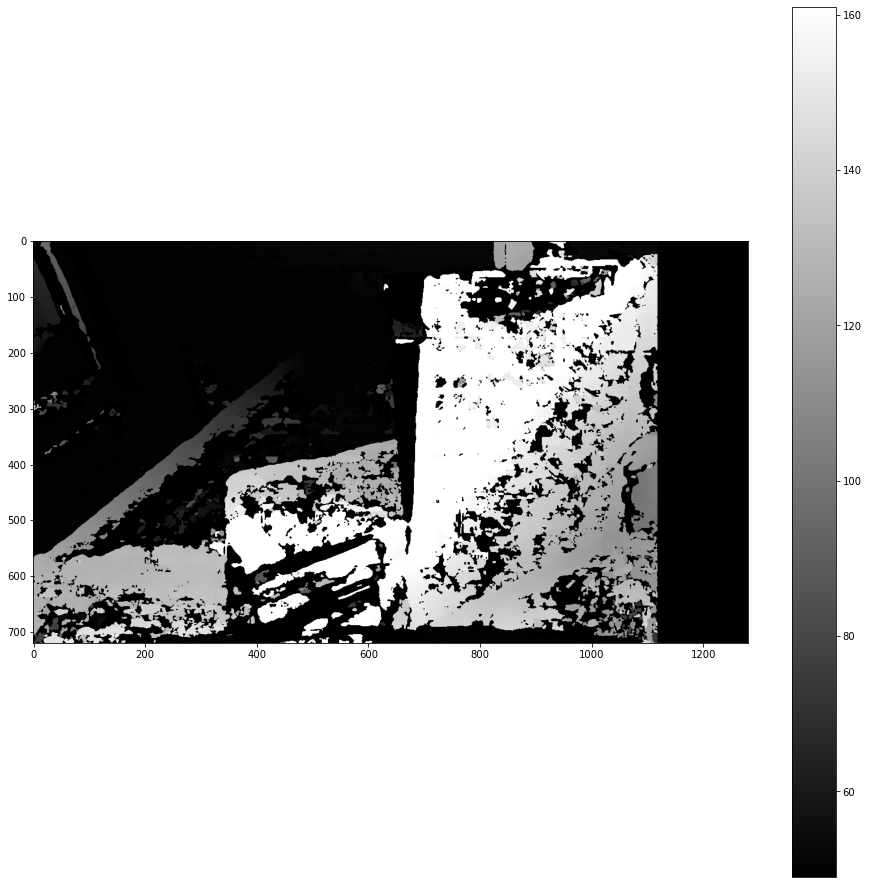

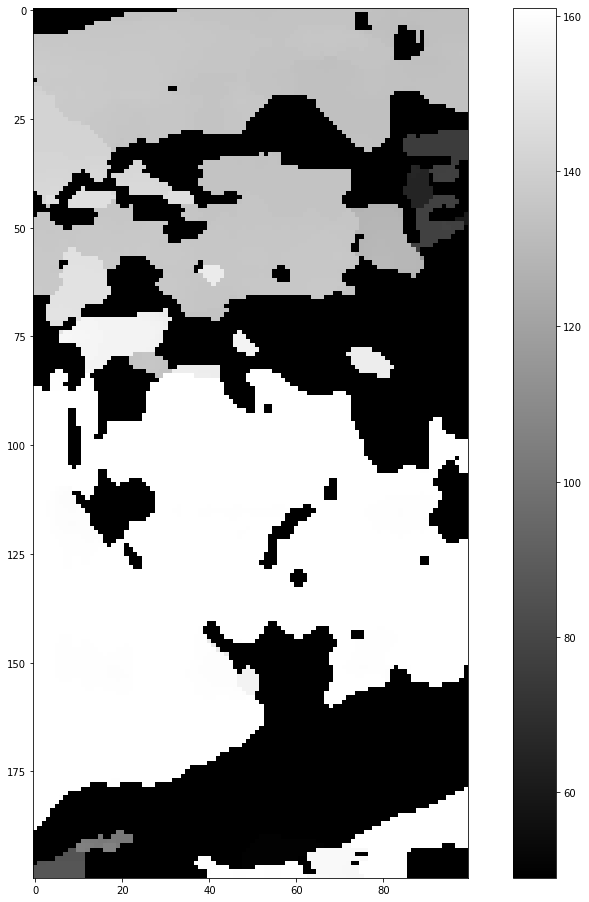

In [22]:
fname_disp_left = './With_Occlusions/left/1585434754_055774689_Left.png'
imgL = cv2.imread(fname_disp_left)
leftRect = cv2.remap(imgL, leftMapX, leftMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
leftGray = cv2.cvtColor(leftRect, cv2.COLOR_BGR2GRAY)

fname_disp_right = './With_Occlusions/right/1585434754_055774689_Right.png'
imgR = cv2.imread(fname_disp_right)
rightRect = cv2.remap(imgR, rightMapX, rightMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
rightGray = cv2.cvtColor(rightRect, cv2.COLOR_BGR2GRAY)

block_size = 11
min_disp = 50
max_disp = 7 * 16
num_disp = max_disp 

stereo_2 = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = block_size,
    uniquenessRatio = 5,
    speckleWindowSize = 15,
    speckleRange = 15,
    disp12MaxDiff = 10,
    P1 = 8 * 3 * block_size ** 2,
    P2 = 32 * 3 * block_size ** 2
)

disparity_2 = stereo_2.compute(rightRect[:, ::-1, :], leftRect[:, ::-1, :]).astype(np.float32)  / 16.0

disparity_2 = disparity_2[:, ::-1]

fig, ax = plt.subplots(figsize = (16,16))
# ax[0].imshow(left_rect, 'gray')
# ax[1].imshow(right_rect, 'gray')
image = ax.imshow(disparity_2, cmap = 'gray')
plt.colorbar(image)

def object_xyzd(start_x, end_x, start_y, end_y, baseline = 120, f = 703.6, centerCol = 640, centerRow = 360):
    region = disparity_2[start_x:end_x, start_y:end_y]
    mean_val = np.median(region[region > region.min()])
    
    fig, ax = plt.subplots(figsize = (16,16))
    image = ax.imshow(region, cmap = 'gray')
    plt.colorbar(image)
    
    depth = baseline * f / mean_val
    
    x_mid = start_x + ((end_x - start_x) / 2)
    u = x_mid - centerRow
    
    y_mid = start_y + ((end_y - start_y) / 2)
    v = y_mid - centerCol
    
    x = v * depth / f
    y = u * depth / f
    
    z = np.sqrt(depth ** 2 - y ** 2 - x ** 2)
    
    return x, y, z, depth
    

Y, X, Z, object_depth = object_xyzd(400, 600, 400, 500)
print(f'''
    Distance from center row downward: {X:.2f} mm,
    Distance from center column right: {Y:.2f} mm,
    Distance from camera to center: {Z:.2f} mm,
    Depth of object: {object_depth:.2f} mm'''
     ) 

210.0
1150.0


57.63210656344723
58.94742771446345
59.40985260903645
58.217955053913606
58.69602104651529
59.43941777555376
56.56119178034727
56.290099210741765
59.41574214914228
57.92767423947378
57.00733532549031
59.0491138524942
59.69167544059159
57.38860092495438
58.12342006375953
58.0771973565331
56.55218083265773
59.2374538352596
60.03801878587474
58.93123000843829
57.0652015191347
57.81601417221461
59.72209410041512
58.38678955742796
58.782469997355825
60.19398955145119
59.61831139165702
58.83120752117861
60.0679028065963
59.83834015015577
59.98763009015946
58.211751824875854
56.94387332919543
58.22426200516415
57.956369231450694
58.08518553316943
58.95123351826322
60.14526514196626
58.3774919206802
58.27949218090537
57.99054457251047
58.57716043802691
57.63381408411609
59.285051369554765
60.731906811041235
59.1953918783476
58.396845275232366
60.57161953412641
59.48000240652811
57.328858113622594
60.80658633410454
58.420705667727276
59.05155578200551
57.80905593156734
57.46314097729094
58.3035